<a href="https://colab.research.google.com/github/SolisProcopioUriel/Modelaci-n-financiera/blob/main/Modelo_Binomial_y_Black_and_scholes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [188]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.stats import binom, norm

#PEDIMOS DATOS AL USUARIO

In [189]:

S_0 = float(input("Digite el valor de S_0(Precio actual): ") or 158)
k = float(input("Digite k(precio de ejercicio): ") or 167)
r = float(input("Digite r(tasa libre de riesgo) en porcentaje(Ejemplo 15%): ") or 12)
r = r/100
T = float(input("Digite el tiempo en meses(T): ") or 10)
T = T/12
n = int(input("Digite el número de periodos(n): ") or 100)
valor_ud = input("¿Tienes valores de 'u' y 'd' para la iteración? Responder 's' en caso de tenerlos y 'n' en caso de no tenerlos: ") or 'n'
if valor_ud == 's':
    u = float(input("Digite el valor de u (factor de subida): ") or 1.1)
    d = float(input("Digite el valor de d (factor de bajada): ") or 0.9)
else:
    sigma = float(input("Digite el valor de sigma: ") or 36)
    sigma = sigma / 100
Tipo = input("De qué tipo es: 'put' si es PUT y 'call' si es un CALL: ") or 'call'
Clase = input("De que clase es: 'a' si es AMERICANA y 'e' si es EUROPEA: ") or 'e'

Digite el valor de S_0(Precio actual): 158
Digite k(precio de ejercicio): 167
Digite r(tasa libre de riesgo) en porcentaje(Ejemplo 15%): 12
Digite el tiempo en meses(T): 10
Digite el número de periodos(n): 100
¿Tienes valores de 'u' y 'd' para la iteración? Responder 's' en caso de tenerlos y 'n' en caso de no tenerlos: n
Digite el valor de sigma: 36
De qué tipo es: 'put' si es PUT y 'call' si es un CALL: call
De que clase es: 'a' si es AMERICANA y 'e' si es EUROPEA: e


#BINOMIAL Y MODELO BLACK ANS SCHOLES

In [190]:
valores_opcion_americana = []
valores_opcion_europea = []
valores_opcion_black_scholes = []

for iteracion in range(1, n + 1):
    dt = T / iteracion

    if valor_ud == 's':
        u = 1 + (u / 100)
        d = 1 - (d / 100)
        sigma = math.log(u) / math.sqrt(dt)
    else:
        u = np.exp(sigma * math.sqrt(dt))
        d = 1 / u

    if Tipo == 'put':
        tc = 1
    else:
        tc = -1

    if u == d:
      print("Advertencia: 'u' y 'd' son iguales, lo que puede causar una división por cero.")
      p = 0  # Asignar un valor predeterminado en este caso
    else:
        p = (math.exp(r * dt) - d) / (u - d)

#-----------------------------ARBOL DE PRECIOS-------------------------------------
    def calcular_arbol_precios(S_0, u, d, iteracion):
        precios = [[0.0 for _ in range(i + 1)] for i in range(iteracion + 1)]
        for i in range(iteracion + 1):
            for j in range(i + 1):
                precios[i][j] = S_0 * (u ** j) * (d ** (i - j))
        return precios

    precios = calcular_arbol_precios(S_0, u, d, iteracion)

#---------------------------PAGOS DE LA ULTIMA COLUMNA----------------------------

    def calcular_pagos_finales(precios, iteracion, k, tc):
        pagos_finales = [0.0 for _ in range(iteracion + 1)]
        for j in range(iteracion + 1):
            pagos_finales[j] = max(0, (tc * k) - (tc * precios[iteracion][j]))
        return pagos_finales

    pagos_finales = calcular_pagos_finales(precios, iteracion, k, tc)

#---------------------------------AMERICNAS----------------------------------------

    def calcular_opcion_americana(precios, iteracion, k, pagos_finales, p, r, dt, tc):
        for i in range(iteracion - 1, -1, -1):
            for j in range(i + 1):
                beneficio_ejercicio = max(0, tc * k - tc * precios[i][j])
                valor_operacion = math.exp(-r * dt) * (
                        p * pagos_finales[j + 1] + (1 - p) * pagos_finales[j])

                if tc == 1 and beneficio_ejercicio > valor_operacion:
                    pagos_finales[j] = beneficio_ejercicio
                else:
                    pagos_finales[j] = valor_operacion

        return pagos_finales[0]

    pagos_finales = calcular_pagos_finales(precios, iteracion, k, tc)
    precio_a = calcular_opcion_americana(precios, iteracion, k, pagos_finales, p, r, dt, tc)
    valores_opcion_americana.append(precio_a)

#-------------------------------------EUROPEAS----------------------------------------------

    def calcular_opcion_europea(pagos_finales, n, p, r, dt):
        precio_e = 0
        for i in range(n + 1):
            vp = math.exp(-r * dt * i)
            precio_e += pagos_finales[i] * binom.pmf(i, n, p)

        precio_e *= vp
        return precio_e

    pagos_finales = calcular_pagos_finales(precios, iteracion, k, tc)
    precio_e = calcular_opcion_europea(pagos_finales, iteracion, p, r, dt)
    valores_opcion_europea.append(precio_e)

#-------------------------------------MODELO BLACK AND SCHOLES-------------------------------

    def calcular_opcion_black_scholes(S_0, k, r, T, sigma, Tipo):
        d1 = (math.log(S_0/k) + (r + (sigma**2)/2)*T)/(sigma*math.sqrt(T))
        d2 = d1 - sigma*math.sqrt(T)
        if Tipo == 'call':
            opcion = S_0 * norm.cdf(d1) - k * math.exp(-r * T) * norm.cdf(d2)
        else:
            opcion = k * math.exp(-r * T) * norm.cdf(-d2) - S_0 * norm.cdf(-d1)
        return opcion

    opcion_bs = calcular_opcion_black_scholes(S_0, k, r, T, sigma, Tipo)
    valores_opcion_black_scholes.append(opcion_bs)

#IMPRIMIR RESULTADOS SEGUN LOS DATOS PROPORCIONADOS POR EL USUARIO

In [191]:
if Tipo == 'put' and Clase == 'a':
  print("El valor del PUT AMERICANA es: ", valores_opcion_americana[-1])
elif Tipo == 'put' and Clase == 'e':
  print("El valor del PUT EUROPEO es: ", valores_opcion_europea[-1])
elif Tipo == 'call' and Clase == 'a':
  print("El valor del CALL AMERICANO es: ", valores_opcion_americana[-1])
else:
  print("El valor del CALL EUROPEO es: ", valores_opcion_europea[-1])

print("El valor con  el modelo Black and Scholes es: ", valores_opcion_black_scholes[0])

if n <= 7:
    print(arbol)
else:
    print("El arbol es demaciado grande para graficar")

El valor del CALL EUROPEO es:  23.797384647750775
El valor con  el modelo Black and Scholes es:  23.801968702234447
El arbol es demaciado grande para graficar


#PARIDAD PUT-CALL

  \begin{equation*}
    p + ke^{-rT} = c + S_0
  \end{equation*}

In [192]:
#--------------------AMERICANAS----------------------------------------------
valores_opcion_americana_1 = []
pagos_finales = calcular_pagos_finales(precios, iteracion, k, -1)
precio_a = calcular_opcion_americana(precios, iteracion, k, pagos_finales, p, r, dt, -1)
valores_opcion_americana_1.append(precio_a)
print("CALL AMERICANO: ",valores_opcion_americana_1[-1])

valores_opcion_americana_2 = []
pagos_finales = calcular_pagos_finales(precios, iteracion, k, 1)
precio_a = calcular_opcion_americana(precios, iteracion, k, pagos_finales, p, r, dt, 1)
valores_opcion_americana_2.append(precio_a)
print("PUT AMERICANO: ",valores_opcion_americana_2[-1])

c_1 = valores_opcion_americana_2[-1] + S_0
p_1 = valores_opcion_americana_1[-1] + k * math.exp(-r*T)

print(c_1)
print(p_1)

if c_1 == p_1:
  print("SE CUMPLE LA ECUACIÓN DE PARIDAD PUT-CALL\n")
else:
  print("NO SE CUMPLE LA ECUACIÓN DE PARIDAD PUT-CALL\n")

#-----------------------EUROPEAS------------------------------------------------

valores_opcion_europea_1 = []
pagos_finales = calcular_pagos_finales(precios, iteracion, k, -1)
precio_e = calcular_opcion_europea(pagos_finales, iteracion, p, r, dt)
valores_opcion_europea_1.append(precio_e)
print("CALL EUROPEO: ", valores_opcion_europea_1[-1])

valores_opcion_europea_2 = []
pagos_finales = calcular_pagos_finales(precios, iteracion, k, 1)
precio_e = calcular_opcion_europea(pagos_finales, iteracion, p, r, dt)
valores_opcion_europea_2.append(precio_e)
print("PUT EUROPEO: ", valores_opcion_europea_2[-1])

c_2 = round(valores_opcion_europea_2[-1] + S_0, 3)
p_2 = round(valores_opcion_europea_1[-1] + k * math.exp(-r*T), 3)

print(c_2)
print(p_2)

if c_2 == p_2:
  print("SE CUMPLE LA ECUACIÓN DE PARIDAD PUT-CALL\n")
else:
  print("NO SE CUMPLE LA ECUACIÓN DE PARIDAD PUT-CALL\n")

CALL AMERICANO:  23.797384647750878
PUT AMERICANO:  19.473018823052943
177.47301882305294
174.90523345975612
NO SE CUMPLE LA ECUACIÓN DE PARIDAD PUT-CALL

CALL EUROPEO:  23.797384647750775
PUT EUROPEO:  16.905233459755365
174.905
174.905
SE CUMPLE LA ECUACIÓN DE PARIDAD PUT-CALL



#PARIDAD BLACK AND SCHOLES

In [193]:
bs_1 = calcular_opcion_black_scholes(S_0, k, r, T, sigma, 'call')
print("El valor con Black and Scholes del CALL EUROPEO es: ", bs_1)

bs_2 = calcular_opcion_black_scholes(S_0, k, r, T, sigma, 'put')
print("El valor con Black and Scholes del PUT EUROPEO es: ", bs_2)

cc = round(bs_1 + k*math.exp(-r*T),2)
print(cc)

pp = round(bs_2 + S_0, 2)
print(pp)

if cc == pp:
  print("SE CUMPLE LA ECUACIÓN DE PARIDAD PUT-CALL\n")
else:
  print("NO SE CUMPLE LA ECUACIÓN DE PARIDAD PUT-CALL\n")

El valor con Black and Scholes del CALL EUROPEO es:  23.801968702234447
El valor con Black and Scholes del PUT EUROPEO es:  16.909817514239705
174.91
174.91
SE CUMPLE LA ECUACIÓN DE PARIDAD PUT-CALL



GRFICA QUE MUESTRA LA CONVERGENCIA

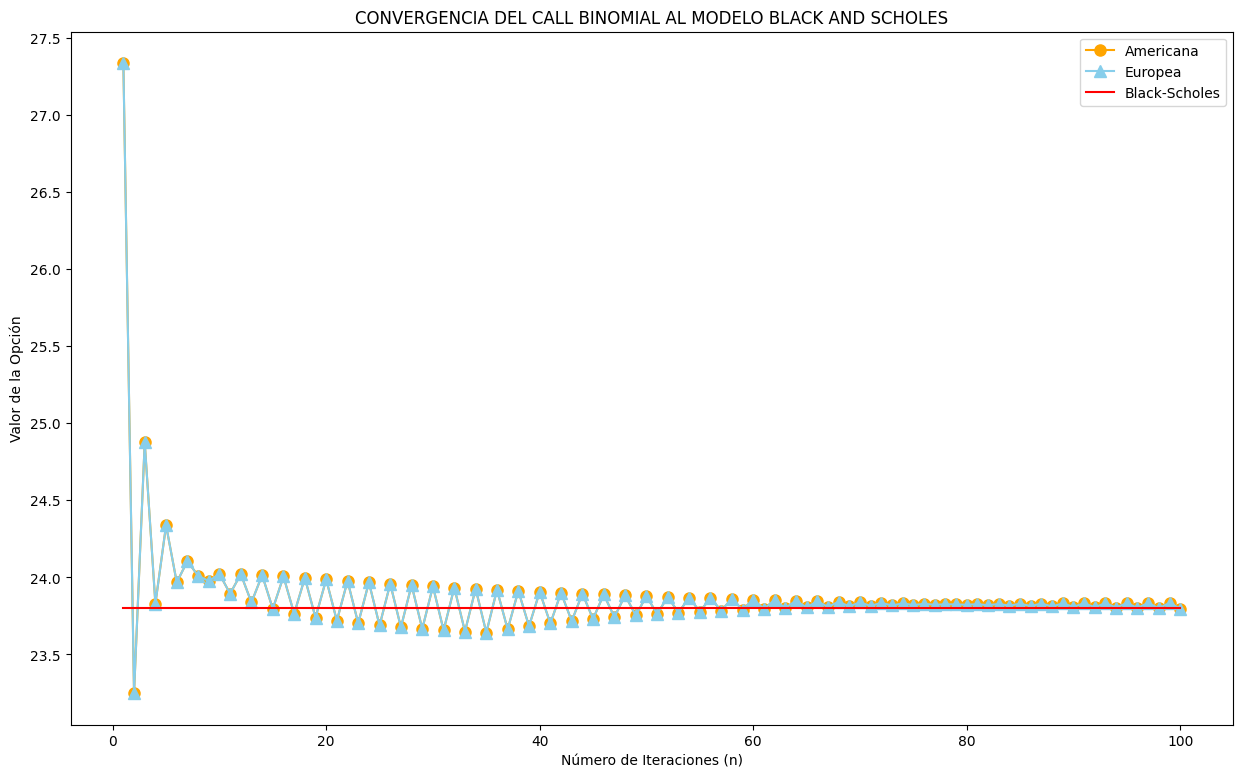

In [194]:
plt.figure(figsize=(15, 9))
n_values = list(range(1, n + 1))
plt.plot(n_values, valores_opcion_americana, label='Americana', marker='o', linestyle='-', color='orange', markersize=8)
plt.plot(n_values, valores_opcion_europea, label='Europea', marker='^', linestyle='-', color='skyblue', markersize=8)
plt.plot(n_values, valores_opcion_black_scholes, label='Black-Scholes', linestyle='-', color='red', markersize=8)
plt.xlabel('Número de Iteraciones (n)')
plt.ylabel('Valor de la Opción')
plt.title(f'CONVERGENCIA DEL {Tipo.upper()} BINOMIAL AL MODELO BLACK AND SCHOLES')
plt.legend()
plt.show()